## Import this notebook to Kaggle for training | Select GPU P100 during run for faster training

In [1]:
!pip install wavemix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00


In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import wavemix
from wavemix.classification import WaveMix
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
class_map = {
    "0": "A",
    "1": "B",
    "2": "C",
    "3": "D",
    "4": "E",
    "5": "F",
    "6": "G",
    "7": "H",
    "8": "I",
    "9": "J",
    "10": "K",
    "11": "L",
    "12": "M",
    "13": "N",
    "14": "O",
    "15": "P",
    "16": "Q",
    "17": "R",
    "18": "S",
    "19": "T",
    "20": "U",
    "21": "V",
    "22": "W",
    "23": "X",
    "24": "Y",
    "25": "Z"
}


In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load EMNIST balanced dataset
data_root = './data'
emnist_data = datasets.EMNIST(root=data_root, split='letters', train=True, download=True, transform=transform)

#Train Val Split
train_size = int(0.8 * len(emnist_data))
val_size = len(emnist_data) - train_size

train_indices = list(range(train_size))
val_indices = list(range(train_size, len(emnist_data)))

# Use Subset to create training and validation datasets
train_dataset = Subset(emnist_data, train_indices)
val_dataset = Subset(emnist_data, val_indices)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Iterate through the data
for images, labels in train_loader:
    print(images.shape)  # Output: (batch_size, 1, 28, 28)
    print(labels.shape)  # Output: (batch_size,)
    break  # Just to see one batch

100%|██████████| 561753746/561753746 [00:06<00:00, 92694506.91it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [5]:
print(len(emnist_data.classes))

27


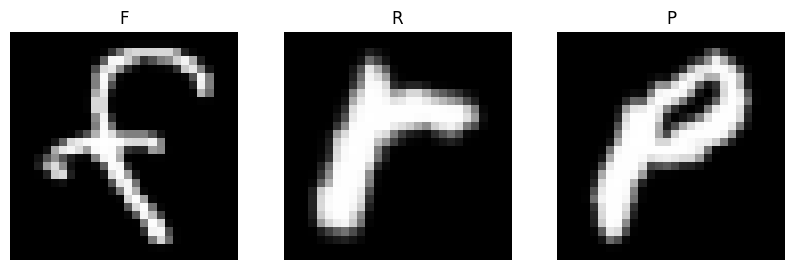

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(10, 8)) 

for i in range(3):
    axs[i].imshow(images[i].squeeze().T, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(class_map[str(labels[i].item() - 1)])
plt.show()

In [8]:
model = WaveMix(
    num_classes= 27, 
    depth= 16,
    mult= 2,
    ff_channel= 192,
    final_dim= 112,
    dropout= 0.5,
    level=1,
    patch_size=2,
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
model.to(device)

WaveMix(
  (layers): ModuleList(
    (0-15): 16 x Level1Waveblock(
      (feedforward): Sequential(
        (0): Conv2d(112, 224, kernel_size=(1, 1), stride=(1, 1))
        (1): GELU(approximate='none')
        (2): Dropout(p=0.5, inplace=False)
        (3): Conv2d(224, 192, kernel_size=(1, 1), stride=(1, 1))
        (4): ConvTranspose2d(192, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (5): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (reduction): Conv2d(112, 28, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (pool): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Rearrange('... () () -> ...')
    (2): Linear(in_features=112, out_features=27, bias=True)
  )
  (conv): Sequential(
    (0): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(56, 112, kernel_size=(2, 2), stride=(2, 2))
    (3): GELU(appr

In [9]:
from tqdm import tqdm

def train():
    best_val = 0
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Training phase
        for images, labels in tqdm(train_loader, desc="Training"):
            images = images.transpose(-1, -2)
            # plt.imshow(images[0].squeeze(0).squeeze(0), cmap='gray')
            # plt.title(class_map[str(labels[0].item() - 1)])
            # plt.show()
            # return
            if isinstance(model, WaveMix):
                images = images.repeat(1, 3, 1, 1)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()  # Accumulate loss

        # Calculate average training loss
        avg_train_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation for validation
            for val_images, val_labels in tqdm(val_loader, desc="Evaluating"):
                val_images = val_images.transpose(-1, -2)
                if isinstance(model, WaveMix):
                    val_images = val_images.repeat(1, 3, 1, 1)
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)  # Forward pass
                val_loss = criterion(val_outputs, val_labels)  # Calculate validation loss
                
                running_val_loss += val_loss.item()  # Accumulate validation loss

                # Calculate accuracy
                _, predicted = torch.max(val_outputs.data, 1)  # Get the index of the max log-probability
                total += val_labels.size(0)  # Total number of labels
                correct += (predicted == val_labels).sum().item()  # Count correct predictions

        # Calculate average validation loss and accuracy
        avg_val_loss = running_val_loss / len(val_loader)
        accuracy = correct / total * 100  # Percentage

        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')
        if accuracy > best_val:
            torch.save(model.state_dict(), f"ocr_wavemix_epoch{epoch}.pth")
            print(f"Better model Accuracy saved")
            best_val = accuracy

    
        
    print("Training and validation complete!")



In [10]:
train()

Training: 100%|██████████| 1560/1560 [02:00<00:00, 12.94it/s]


Epoch [1/20], Training Loss: 0.5175


Evaluating: 100%|██████████| 390/390 [00:11<00:00, 34.22it/s]


Epoch [1/20], Validation Loss: 0.2827, Accuracy: 90.45%
Better model Accuracy saved


Training: 100%|██████████| 1560/1560 [01:58<00:00, 13.15it/s]


Epoch [2/20], Training Loss: 0.2569


Evaluating: 100%|██████████| 390/390 [00:11<00:00, 34.94it/s]


Epoch [2/20], Validation Loss: 0.2336, Accuracy: 92.26%
Better model Accuracy saved


Training: 100%|██████████| 1560/1560 [01:59<00:00, 13.08it/s]


Epoch [3/20], Training Loss: 0.2251


Evaluating: 100%|██████████| 390/390 [00:11<00:00, 35.42it/s]


Epoch [3/20], Validation Loss: 0.1970, Accuracy: 93.10%
Better model Accuracy saved


Training: 100%|██████████| 1560/1560 [01:59<00:00, 13.08it/s]


Epoch [4/20], Training Loss: 0.2071


Evaluating: 100%|██████████| 390/390 [00:11<00:00, 34.95it/s]


Epoch [4/20], Validation Loss: 0.1963, Accuracy: 93.46%
Better model Accuracy saved


Training: 100%|██████████| 1560/1560 [01:59<00:00, 13.09it/s]


Epoch [5/20], Training Loss: 0.1954


Evaluating: 100%|██████████| 390/390 [00:11<00:00, 35.04it/s]


Epoch [5/20], Validation Loss: 0.1792, Accuracy: 94.16%
Better model Accuracy saved


Training: 100%|██████████| 1560/1560 [01:58<00:00, 13.12it/s]


Epoch [6/20], Training Loss: 0.1838


Evaluating: 100%|██████████| 390/390 [00:11<00:00, 35.35it/s]


Epoch [6/20], Validation Loss: 0.1631, Accuracy: 94.39%
Better model Accuracy saved


Training: 100%|██████████| 1560/1560 [01:59<00:00, 13.11it/s]


Epoch [7/20], Training Loss: 0.1753


Evaluating: 100%|██████████| 390/390 [00:11<00:00, 34.98it/s]


Epoch [7/20], Validation Loss: 0.1689, Accuracy: 94.23%


Training: 100%|██████████| 1560/1560 [01:59<00:00, 13.11it/s]


Epoch [8/20], Training Loss: 0.1690


Evaluating: 100%|██████████| 390/390 [00:11<00:00, 35.21it/s]


Epoch [8/20], Validation Loss: 0.1680, Accuracy: 94.23%


Training: 100%|██████████| 1560/1560 [01:59<00:00, 13.06it/s]


Epoch [9/20], Training Loss: 0.1625


Evaluating: 100%|██████████| 390/390 [00:11<00:00, 34.84it/s]


Epoch [9/20], Validation Loss: 0.1568, Accuracy: 94.62%
Better model Accuracy saved


Training: 100%|██████████| 1560/1560 [01:58<00:00, 13.13it/s]


Epoch [10/20], Training Loss: 0.1564


Evaluating: 100%|██████████| 390/390 [00:11<00:00, 34.44it/s]


Epoch [10/20], Validation Loss: 0.1590, Accuracy: 94.68%
Better model Accuracy saved


Training: 100%|██████████| 1560/1560 [01:59<00:00, 13.10it/s]


Epoch [11/20], Training Loss: 0.1527


Evaluating: 100%|██████████| 390/390 [00:11<00:00, 34.41it/s]


Epoch [11/20], Validation Loss: 0.1562, Accuracy: 94.61%


Training: 100%|██████████| 1560/1560 [01:56<00:00, 13.35it/s]


Epoch [12/20], Training Loss: 0.1474


Evaluating: 100%|██████████| 390/390 [00:11<00:00, 35.13it/s]


Epoch [12/20], Validation Loss: 0.1538, Accuracy: 94.74%
Better model Accuracy saved


Training: 100%|██████████| 1560/1560 [01:57<00:00, 13.29it/s]


Epoch [13/20], Training Loss: 0.1440


Evaluating: 100%|██████████| 390/390 [00:10<00:00, 35.99it/s]


Epoch [13/20], Validation Loss: 0.1497, Accuracy: 94.88%
Better model Accuracy saved


Training: 100%|██████████| 1560/1560 [01:57<00:00, 13.32it/s]


Epoch [14/20], Training Loss: 0.1406


Evaluating: 100%|██████████| 390/390 [00:10<00:00, 35.61it/s]


Epoch [14/20], Validation Loss: 0.1459, Accuracy: 94.99%
Better model Accuracy saved


Training: 100%|██████████| 1560/1560 [01:56<00:00, 13.34it/s]


Epoch [15/20], Training Loss: 0.1368


Evaluating: 100%|██████████| 390/390 [00:10<00:00, 36.17it/s]


Epoch [15/20], Validation Loss: 0.1463, Accuracy: 94.91%


Training: 100%|██████████| 1560/1560 [01:56<00:00, 13.37it/s]


Epoch [16/20], Training Loss: 0.1351


Evaluating: 100%|██████████| 390/390 [00:10<00:00, 36.27it/s]


Epoch [16/20], Validation Loss: 0.1510, Accuracy: 94.94%


Training: 100%|██████████| 1560/1560 [01:56<00:00, 13.34it/s]


Epoch [17/20], Training Loss: 0.1318


Evaluating: 100%|██████████| 390/390 [00:10<00:00, 35.69it/s]


Epoch [17/20], Validation Loss: 0.1472, Accuracy: 95.23%
Better model Accuracy saved


Training: 100%|██████████| 1560/1560 [01:56<00:00, 13.35it/s]


Epoch [18/20], Training Loss: 0.1297


Evaluating: 100%|██████████| 390/390 [00:10<00:00, 35.55it/s]


Epoch [18/20], Validation Loss: 0.1444, Accuracy: 95.08%


Training: 100%|██████████| 1560/1560 [01:56<00:00, 13.36it/s]


Epoch [19/20], Training Loss: 0.1264


Evaluating: 100%|██████████| 390/390 [00:11<00:00, 35.17it/s]


Epoch [19/20], Validation Loss: 0.1452, Accuracy: 94.98%


Training: 100%|██████████| 1560/1560 [01:56<00:00, 13.37it/s]


Epoch [20/20], Training Loss: 0.1241


Evaluating: 100%|██████████| 390/390 [00:11<00:00, 35.09it/s]

Epoch [20/20], Validation Loss: 0.1554, Accuracy: 94.78%
Training and validation complete!
